In [259]:
import setup as set
import data_directory as dd

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.colors import LogNorm
from matplotlib import cm


def theta01_sweep_calc_load(t_set, factor, points):
    # create some sample data
    dphi = 1e-2
    X, Y = np.meshgrid(np.linspace(-dphi, np.pi+dphi, points), np.linspace(-dphi, np.pi+dphi, points))

    t_set.factor0 = factor
    t_set.factor1 = factor
    t_set.factor2 = factor
    t_set.factor3 = factor

    params_dict = param_dict()
    fill_param_dict(params_dict, factor, points, t_set.method)
    Z = dd.load_data(params_dict, '0_current-after-blockade')
    
    if Z is None:
        Z = np.abs(np.array([current_calculation(t_set, X[idx], Y[idx], idx) for idx, dummy in np.ndenumerate(X) ] ).reshape(X.shape+(2,) ) )
        dd.save_data(Z, params_dict, '0_current-after-blockade')

    return X, Y, Z


def current_calculation(t_set, x, y, idx):
    print(idx)
    t_set.th0	= x
    t_set.th1	= y

    t_set.adjust_to_z_blockade()
    gamma_0		= t_set.gamma_00
    gamma_1		= t_set.gamma_01

    t_set.gamma_01	= 0.0
    t_set.gamma_00	= gamma_0
    t_set.initialize_box()
    t_set.connect_box()
    sys	= t_set.build_qmeq_sys()
    sys.solve(qdq=False, rotateq=False)
    current		= sys.current[0]

    t_set.gamma_01	= gamma_1
    t_set.gamma_00	= 0.0
    t_set.initialize_box()
    t_set.connect_box()
    sys	= t_set.build_qmeq_sys()
    sys.solve(qdq=False, rotateq=False)
    return [current, sys.current[0]]

def theta0_variation_plot(fig, ax, t_set, thetas):
    current_0	= []
    current_1	= []
    for theta in thetas:
        t_set.th0	= theta
        t_set.adjust_to_z_blockade()
        gamma_0		= t_set.gamma_00
        gamma_1		= t_set.gamma_01

        t_set.gamma_01	= 0
        t_set.initialize_box()
        t_set.connect_box()
        sys	= t_set.build_qmeq_sys()
        sys.solve(qdq=False, rotateq=False)
        current_0.append(sys.current[0] )

        t_set.gamma_01	= gamma_1
        t_set.gamma_00	= 0.0
        t_set.initialize_box()
        t_set.connect_box()
        sys	= t_set.build_qmeq_sys()
        sys.solve(qdq=False, rotateq=False)
        current_1.append(sys.current[0] )


    current	= np.transpose(np.array([current_0, current_1]) )

    ax.scatter(thetas, current[:,0], marker='x', label='site 0' )
    ax.scatter(thetas, current[:,1], marker='x', label='site 1' )
    thetas	= np.linspace(0, np.pi, 1000)

    ax.plot(thetas, np.transpose(func(thetas)[2] ), label='analytics' )
    ax.legend()

def func(theta):
    gamma_plus	= 2*(1+np.sin(theta))/np.abs(np.cos(theta) )
    gamma_minus	= 2*(1-np.sin(theta))/np.abs(np.cos(theta) )
    gamma_drain	= 4
    gamma_eff	= np.abs(np.cos(theta) )
    gamma_eff	= 1/(1/gamma_plus+1/gamma_minus+2/gamma_drain)
    return np.array([gamma_plus, gamma_minus, 2*gamma_eff] )

params_dict = param_dict()

def theta01_sweep_plot(data, fig, axes):
    zmax = 1e-1
    zmin = 1e-3
    #factors = [1, 0.5, 0.25, 0.1]
    factors = [1, 0.5, 0.25]
    points = 100
    for idx, factor in enumerate(factors):
        ax = axes[idx]
        #dd.save_data(data_set, params_dict, '0_current-after-blockade'
        
        X, Y, data_set = theta01_sweep_calc_load(t_set, factor, points)

        daten = np.abs(data_set[:,:,0]-data_set[:,:,1])/data_set[:,:,1]
        levels = np.linspace(zmin, zmax, 5)
        c = ax.contourf(X, Y, daten, norm=LogNorm(), locator=ticker.LogLocator(), cmap=cm.viridis, extend='both', levels=levels)
        #c = ax.contourf(X, Y, daten, norm=LogNorm(), locator=ticker.LogLocator())

        # Set axis labels and title
        ax.set_xlabel(r"$\theta_0$")
        ax.set_ylabel(r"$\theta_1$")

        # Create colorbar
        cb = fig.colorbar(c)

        cb.ax.set_title(r"$|\Delta I|$")
        cb.ax.locator_params(axis='y', nbins=4 )
        ticks = np.arange(0, np.pi+1, np.pi/2)
        tick_labels = ['0', r'$\pi/2$', r'$\pi$']
        ax.set_xticks(ticks)
        ax.set_xticklabels(tick_labels)
        ax.set_yticks(ticks)
        ax.set_yticklabels(tick_labels)

Data loaded from:  /Users/ma0274ni/Documents/projects/majorana_box/data/fusion_rule/format_0_current-after-blockade/data_factor0-1_factor1-1_factor2-1_factor3-1_gridpoints-100_routine-py1vN.npy
Data loaded from:  /Users/ma0274ni/Documents/projects/majorana_box/data/fusion_rule/format_0_current-after-blockade/data_factor0-0.5_factor1-0.5_factor2-0.5_factor3-0.5_gridpoints-100_routine-py1vN.npy
Data loaded from:  /Users/ma0274ni/Documents/projects/majorana_box/data/fusion_rule/format_0_current-after-blockade/data_factor0-0.25_factor1-0.25_factor2-0.25_factor3-0.25_gridpoints-100_routine-py1vN.npy


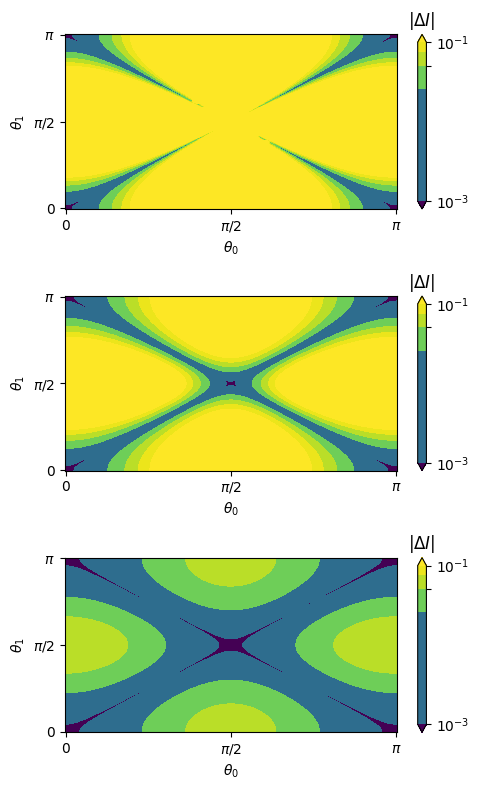

In [260]:
import importlib
importlib.reload(dd)
fig, axes = plt.subplots(3,1, figsize=(5,8))
theta01_sweep_plot(data, fig, axes)
fig.tight_layout()
#Save created plot as regular picture
#plt.savefig('/Users/ma0274ni/Documents/projects/majorana_box/papers/fusion/plots/ABS-box_different_current_f0=f1=f2=f3-1.0-0.5-0.25_gridpoints-100_1vN.pdf', format='pdf')
#Save created plot as finite zmin, zmax
plt.savefig('/Users/ma0274ni/Documents/projects/majorana_box/papers/fusion/plots/ABS-box_different_current_f0=f1=f2=f3-1.0-0.5-0.25_gridpoints-100_zmin-1e-3_zmax-1e-1_1vN.pdf', format='pdf')

plt.show()

In [152]:
def param_dict():
    params = {
        "factor0": 0.0,
        "factor1": 0.0,
        "factor2": 0.0,
        "factor3": 0.0,
        "gridpoints": 0,
        "routine": "1vN"
    }
    return params

def fill_param_dict(params, factor, points, method):
    params['factor0'] = factor
    params['factor1'] = factor
    params['factor2'] = factor
    params['factor3'] = factor
    params['gridpoints'] = points
    params['routine'] = method
    
